In [1]:
import os
import csv
import cv2
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold
import random

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import torchvision
from torchvision import transforms


from utils.imageprocess import image_transformer, image_processor
from utils.EarlyStopping import EarlyStopping
from utils.dataloader import CustomDataLoader
from utils.radams import RAdam

from warmup_scheduler import GradualWarmupScheduler

from tqdm import tqdm
import logging

In [2]:
from src.model import PlainResnet50, CustomResnet50, PlainEfficientnetB4

In [3]:
logger = logging.getLogger(__name__)
logging.basicConfig(format="%(asctime)s : %(message)s", 
                    level=logging.INFO,
                    handlers=[
                        logging.FileHandler('./logs/pretraining_log'),
                        logging.StreamHandler()
                    ])

In [4]:
# Early Stopper
from utils.EarlyStopping import EarlyStopping

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")

Current Device: cuda:0


In [6]:
transform_dict = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((40, 40)),
        transforms.Pad(108, fill=0, padding_mode='constant'),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        
        transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
        transforms.RandomAffine(degrees=0,
                                translate=(0.3, 0.3),
                                fillcolor=0),
        transforms.RandomAffine(degrees=0,
                                shear=(0, 10, 0, 10)),
        
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((40, 40)),
        transforms.Pad(108, fill=0, padding_mode='constant'),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
}

trainset = torchvision.datasets.EMNIST(root='./dataset/emnist_dataset',
                                       split='letters',
                                       train=True,
                                       download=True,
                                       transform=transform_dict['train'])

testset = torchvision.datasets.EMNIST(root='./dataset/emnist_dataset',
                                      split='letters',
                                      train=False,
                                      download=True,
                                      transform=transform_dict['test'])

/home/sks/anaconda3/envs/dacon/lib/python3.8/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
2021-02-12 13:01:05,219 : Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


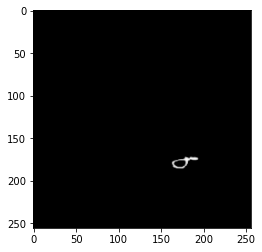

In [7]:
plt.imshow(trainset[2][0].permute(1,2,0))

In [8]:
# train_ratio = 0.8
# train_len = int(len(trainset) * train_ratio)
# val_len = len(trainset) - train_len
# logger.info(f'Train Length: {train_len}, Validation Length: {val_len}')

In [9]:
# train_set, val_set = torch.utils.data.random_split(trainset, lengths=[train_len, val_len])

In [10]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal_(m.weight)
        
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)
        
    elif classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def train_model(model=None, epochs=50, learning_rate=0.002, *loaders):
    
    #model.apply(weights_init)
    
    # Dataloaders (train/val)
    train_loader = loaders[0]
    val_loader = loaders[1]
    
    # Early Stopper
    early_stopping = EarlyStopping(patience=7, verbose=False, path='./pretrained_model/plain_efficientnetb4_ckpt.pth')
    
    loss_function = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = RAdam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4)
    
    
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs/4)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer,
                                                        milestones=[int(epochs*0.3), int(epochs*0.6)],
                                                        gamma=0.5)
    
    warmup_epochs = int(epochs * 0.15)
    lr_warmup = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=warmup_epochs, after_scheduler=lr_scheduler)
    #decayRate = 0.998
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)
    
    # amp
    scaler = amp.GradScaler()
    
    
    train_tot_num = train_loader.dataset.__len__()
    val_tot_num = val_loader.dataset.__len__()
    
    train_loss_sum, train_acc_sum = 0.0, 0.0
    val_loss_sum, val_acc_sum = 0.0, 0.0
    
    logger.info(f'Training begins: epochs={epochs}')
    for epoch in range(epochs):
        logger.info(f'Epoch: {epoch+1}')
        if epoch <= warmup_epochs:
            lr_warmup.step()
        
        torch.cuda.empty_cache()
        model.train()
        
        logger.info(f"Learning Rate : {optimizer.param_groups[0]['lr']:.6f}")
        
        train_tmp_corrects_sum, train_tmp_len = 0, 0
        for idx, (train_X, train_Y) in enumerate(train_loader):    
            
            train_tmp_len += len(train_Y)
            
            train_X = train_X.to(device)
            train_Y = train_Y.to(device)
            
            optimizer.zero_grad()
            
            with amp.autocast():
                train_pred = model(train_X)
                train_loss = loss_function(train_pred, train_Y-1)
            
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Accuracy
            pred_labels = torch.argmax(train_pred, axis=1)
            train_acc = (pred_labels==(train_Y-1)).sum()
            
            train_acc_sum += train_acc.item()
            train_loss_sum += train_loss.item()
            
            train_tmp_corrects_sum += train_acc.item()
            
            # Check between batches
            if (idx+1) % 500 == 0:
                print(f"----- {str((idx+1)).zfill(5)} / {len(train_loader)}th batch | Train Acc: {train_tmp_corrects_sum/train_tmp_len*100:.4f}%")
                
                # initialization
                train_tmp_corrects_sum, train_tmp_len = 0, 0
            
        with torch.no_grad():
 
            for idx, (val_X, val_Y) in enumerate(val_loader):

                val_X, val_Y = val_X.to(device), val_Y.to(device)
                val_pred = model(val_X)
                val_loss = loss_function(val_pred, val_Y-1)
                
                val_pred_labels = torch.argmax(val_pred, axis=1)
                val_acc = (val_pred_labels==(val_Y-1)).sum()
                
                val_acc_sum += val_acc.item()
                val_loss_sum += val_loss.item()
        
        train_accuracy = train_acc_sum / train_tot_num * 100
        val_accuracy = val_acc_sum / val_tot_num * 100
        
        logger.info(f"Epoch: {epoch+1} | Training Loss: {train_loss_sum/train_tot_num:.4f} | Val Loss: {val_loss_sum/val_tot_num:.4f} | " \
              f"Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")
        
        train_loss_sum, train_acc_sum = 0.0, 0.0
        val_loss_sum, val_acc_sum = 0.0, 0.0
        
        early_stopping(-val_accuracy, model)

        if early_stopping.early_stop:
            logger.info("Early stopping condition met --- TRAINING STOPPED")
            break
        
        lr_scheduler.step()
        
    return model

In [12]:
# model

# resnet_model = resnet50().to(device)
# resnet_model.fc = nn.Sequential(
#     nn.Linear(2048, 256),
#     nn.BatchNorm1d(256),
    
#     nn.Linear(256, 26),
# )


In [13]:
# 모델 선언
model = PlainEfficientnetB4().to(device)

Loaded pretrained weights for efficientnet-b4


In [14]:
learning_rate = 0.0025
epochs = 50

model_fit = train_model(model, epochs, learning_rate, train_loader, test_loader)

2021-02-12 13:04:45,386 : Training begins: epochs=50
2021-02-12 13:04:45,386 : Epoch: 1
/home/sks/anaconda3/envs/dacon/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
2021-02-12 13:04:45,388 : Learning Rate : 0.000357
/home/sks/COMPETITION/DACON/computer_vision2/utils/radams.py:45: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Tri

----- 00500 / 3900th batch | Train Acc: 50.8938%
----- 01000 / 3900th batch | Train Acc: 83.6125%
----- 01500 / 3900th batch | Train Acc: 87.9688%
----- 02000 / 3900th batch | Train Acc: 88.9375%
----- 02500 / 3900th batch | Train Acc: 89.4062%
----- 03000 / 3900th batch | Train Acc: 90.7000%
----- 03500 / 3900th batch | Train Acc: 90.9813%


2021-02-12 13:27:13,012 : Epoch: 1 | Training Loss: 0.0159 | Val Loss: 0.0074 | Train Acc: 84.06% | Val Acc: 91.73%
2021-02-12 13:27:13,105 : Epoch: 2
2021-02-12 13:27:13,224 : Learning Rate : 0.000714


----- 00500 / 3900th batch | Train Acc: 88.7563%
----- 01000 / 3900th batch | Train Acc: 89.9000%
----- 01500 / 3900th batch | Train Acc: 90.0875%
----- 02000 / 3900th batch | Train Acc: 91.3375%
----- 02500 / 3900th batch | Train Acc: 91.2937%
----- 03000 / 3900th batch | Train Acc: 91.8875%
----- 03500 / 3900th batch | Train Acc: 91.5812%


2021-02-12 13:49:44,858 : Epoch: 2 | Training Loss: 0.0087 | Val Loss: 0.0068 | Train Acc: 90.84% | Val Acc: 92.67%
2021-02-12 13:49:45,069 : Epoch: 3
2021-02-12 13:49:45,211 : Learning Rate : 0.001071


----- 00500 / 3900th batch | Train Acc: 90.5062%
----- 01000 / 3900th batch | Train Acc: 90.6937%
----- 01500 / 3900th batch | Train Acc: 91.3188%
----- 02000 / 3900th batch | Train Acc: 92.0500%
----- 02500 / 3900th batch | Train Acc: 91.7562%
----- 03000 / 3900th batch | Train Acc: 91.8562%
----- 03500 / 3900th batch | Train Acc: 92.0062%


2021-02-12 14:12:15,973 : Epoch: 3 | Training Loss: 0.0080 | Val Loss: 0.0078 | Train Acc: 91.51% | Val Acc: 91.87%
2021-02-12 14:12:15,974 : Epoch: 4
2021-02-12 14:12:16,097 : Learning Rate : 0.001429


EarlyStopping counter: 1 out of 7
----- 00500 / 3900th batch | Train Acc: 91.4937%
----- 01000 / 3900th batch | Train Acc: 91.2250%
----- 01500 / 3900th batch | Train Acc: 91.7250%
----- 02000 / 3900th batch | Train Acc: 92.0625%
----- 02500 / 3900th batch | Train Acc: 92.4750%
----- 03000 / 3900th batch | Train Acc: 92.0125%
----- 03500 / 3900th batch | Train Acc: 92.1625%


2021-02-12 14:34:47,741 : Epoch: 4 | Training Loss: 0.0076 | Val Loss: 0.0069 | Train Acc: 91.95% | Val Acc: 92.38%
2021-02-12 14:34:47,742 : Epoch: 5
2021-02-12 14:34:47,867 : Learning Rate : 0.001786


EarlyStopping counter: 2 out of 7
----- 00500 / 3900th batch | Train Acc: 91.5000%
----- 01000 / 3900th batch | Train Acc: 91.8000%
----- 01500 / 3900th batch | Train Acc: 92.4813%
----- 02000 / 3900th batch | Train Acc: 91.8750%
----- 02500 / 3900th batch | Train Acc: 92.2562%
----- 03000 / 3900th batch | Train Acc: 92.6188%
----- 03500 / 3900th batch | Train Acc: 92.6125%


2021-02-12 14:57:19,787 : Epoch: 5 | Training Loss: 0.0074 | Val Loss: 0.0063 | Train Acc: 92.21% | Val Acc: 93.39%
2021-02-12 14:57:20,059 : Epoch: 6
2021-02-12 14:57:20,221 : Learning Rate : 0.002143


----- 00500 / 3900th batch | Train Acc: 92.0312%
----- 01000 / 3900th batch | Train Acc: 92.4750%
----- 01500 / 3900th batch | Train Acc: 92.1125%
----- 02000 / 3900th batch | Train Acc: 92.3750%
----- 02500 / 3900th batch | Train Acc: 92.1500%
----- 03000 / 3900th batch | Train Acc: 92.7875%
----- 03500 / 3900th batch | Train Acc: 93.0875%


2021-02-12 15:19:53,413 : Epoch: 6 | Training Loss: 0.0071 | Val Loss: 0.0061 | Train Acc: 92.43% | Val Acc: 93.65%
2021-02-12 15:19:53,637 : Epoch: 7
2021-02-12 15:19:53,787 : Learning Rate : 0.002500


----- 00500 / 3900th batch | Train Acc: 92.6312%
----- 01000 / 3900th batch | Train Acc: 92.2687%
----- 01500 / 3900th batch | Train Acc: 92.8125%
----- 02000 / 3900th batch | Train Acc: 92.5375%
----- 02500 / 3900th batch | Train Acc: 92.5875%
----- 03000 / 3900th batch | Train Acc: 92.7687%
----- 03500 / 3900th batch | Train Acc: 93.1625%


2021-02-12 15:42:24,866 : Epoch: 7 | Training Loss: 0.0069 | Val Loss: 0.0076 | Train Acc: 92.69% | Val Acc: 91.71%
2021-02-12 15:42:24,867 : Epoch: 8
2021-02-12 15:42:25,007 : Learning Rate : 0.001912


EarlyStopping counter: 1 out of 7
----- 00500 / 3900th batch | Train Acc: 93.6125%
----- 01000 / 3900th batch | Train Acc: 93.6750%
----- 01500 / 3900th batch | Train Acc: 93.7438%
----- 02000 / 3900th batch | Train Acc: 93.3438%
----- 02500 / 3900th batch | Train Acc: 93.4313%
----- 03000 / 3900th batch | Train Acc: 93.5438%
----- 03500 / 3900th batch | Train Acc: 93.6187%


2021-02-12 16:04:53,973 : Epoch: 8 | Training Loss: 0.0059 | Val Loss: 0.0060 | Train Acc: 93.58% | Val Acc: 93.69%
2021-02-12 16:04:54,204 : Epoch: 9
2021-02-12 16:04:54,329 : Learning Rate : 0.001351


----- 00500 / 3900th batch | Train Acc: 94.3563%
----- 01000 / 3900th batch | Train Acc: 94.3750%
----- 01500 / 3900th batch | Train Acc: 94.3250%
----- 02000 / 3900th batch | Train Acc: 94.4062%
----- 02500 / 3900th batch | Train Acc: 94.5063%
----- 03000 / 3900th batch | Train Acc: 94.1688%
----- 03500 / 3900th batch | Train Acc: 94.2375%


2021-02-12 16:27:22,697 : Epoch: 9 | Training Loss: 0.0051 | Val Loss: 0.0052 | Train Acc: 94.36% | Val Acc: 94.38%
2021-02-12 16:27:22,919 : Epoch: 10
2021-02-12 16:27:23,066 : Learning Rate : 0.000853


----- 00500 / 3900th batch | Train Acc: 95.0438%
----- 01000 / 3900th batch | Train Acc: 94.9062%
----- 01500 / 3900th batch | Train Acc: 94.6937%
----- 02000 / 3900th batch | Train Acc: 95.0625%
----- 02500 / 3900th batch | Train Acc: 95.3812%
----- 03000 / 3900th batch | Train Acc: 94.9125%
----- 03500 / 3900th batch | Train Acc: 94.9250%


2021-02-12 16:49:51,889 : Epoch: 10 | Training Loss: 0.0044 | Val Loss: 0.0047 | Train Acc: 94.96% | Val Acc: 94.75%
2021-02-12 16:49:52,116 : Epoch: 11
2021-02-12 16:49:52,269 : Learning Rate : 0.000449


----- 00500 / 3900th batch | Train Acc: 95.1250%
----- 01000 / 3900th batch | Train Acc: 95.5375%
----- 01500 / 3900th batch | Train Acc: 95.5438%
----- 02000 / 3900th batch | Train Acc: 95.4000%
----- 02500 / 3900th batch | Train Acc: 95.2938%
----- 03000 / 3900th batch | Train Acc: 95.5562%
----- 03500 / 3900th batch | Train Acc: 95.4438%


2021-02-12 17:12:20,947 : Epoch: 11 | Training Loss: 0.0039 | Val Loss: 0.0044 | Train Acc: 95.42% | Val Acc: 95.05%
2021-02-12 17:12:21,173 : Epoch: 12
2021-02-12 17:12:21,322 : Learning Rate : 0.000165


----- 00500 / 3900th batch | Train Acc: 95.7500%
----- 01000 / 3900th batch | Train Acc: 95.7188%
----- 01500 / 3900th batch | Train Acc: 95.5187%
----- 02000 / 3900th batch | Train Acc: 95.6812%
----- 02500 / 3900th batch | Train Acc: 95.9000%
----- 03000 / 3900th batch | Train Acc: 95.9438%
----- 03500 / 3900th batch | Train Acc: 95.8625%


2021-02-12 17:34:51,400 : Epoch: 12 | Training Loss: 0.0035 | Val Loss: 0.0042 | Train Acc: 95.77% | Val Acc: 95.35%
2021-02-12 17:34:51,644 : Epoch: 13
2021-02-12 17:34:51,768 : Learning Rate : 0.000019


----- 00500 / 3900th batch | Train Acc: 95.9562%
----- 01000 / 3900th batch | Train Acc: 95.9062%
----- 01500 / 3900th batch | Train Acc: 96.1000%
----- 02000 / 3900th batch | Train Acc: 96.1000%
----- 02500 / 3900th batch | Train Acc: 95.8937%
----- 03000 / 3900th batch | Train Acc: 96.0750%
----- 03500 / 3900th batch | Train Acc: 96.0000%


2021-02-12 17:57:17,921 : Epoch: 13 | Training Loss: 0.0033 | Val Loss: 0.0041 | Train Acc: 96.02% | Val Acc: 95.32%
2021-02-12 17:57:17,921 : Epoch: 14
2021-02-12 17:57:18,073 : Learning Rate : 0.000019


EarlyStopping counter: 1 out of 7
----- 00500 / 3900th batch | Train Acc: 95.8688%
----- 01000 / 3900th batch | Train Acc: 96.0563%
----- 01500 / 3900th batch | Train Acc: 95.9750%
----- 02000 / 3900th batch | Train Acc: 96.0063%
----- 02500 / 3900th batch | Train Acc: 96.1000%
----- 03000 / 3900th batch | Train Acc: 96.0187%
----- 03500 / 3900th batch | Train Acc: 96.2313%


2021-02-12 18:19:47,971 : Epoch: 14 | Training Loss: 0.0033 | Val Loss: 0.0041 | Train Acc: 96.03% | Val Acc: 95.47%
2021-02-12 18:19:48,197 : Epoch: 15
2021-02-12 18:19:48,360 : Learning Rate : 0.000165


----- 00500 / 3900th batch | Train Acc: 95.6875%
----- 01000 / 3900th batch | Train Acc: 96.0187%
----- 01500 / 3900th batch | Train Acc: 95.8375%
----- 02000 / 3900th batch | Train Acc: 95.9313%
----- 02500 / 3900th batch | Train Acc: 95.9375%
----- 03000 / 3900th batch | Train Acc: 95.8063%
----- 03500 / 3900th batch | Train Acc: 95.9812%


2021-02-12 18:42:17,903 : Epoch: 15 | Training Loss: 0.0034 | Val Loss: 0.0041 | Train Acc: 95.89% | Val Acc: 95.39%
2021-02-12 18:42:17,903 : Epoch: 16
2021-02-12 18:42:18,030 : Learning Rate : 0.000449


EarlyStopping counter: 1 out of 7
----- 00500 / 3900th batch | Train Acc: 95.8187%
----- 01000 / 3900th batch | Train Acc: 95.5375%
----- 01500 / 3900th batch | Train Acc: 95.3688%
----- 02000 / 3900th batch | Train Acc: 95.7250%
----- 02500 / 3900th batch | Train Acc: 95.5500%
----- 03000 / 3900th batch | Train Acc: 95.3937%
----- 03500 / 3900th batch | Train Acc: 95.8750%


2021-02-12 19:04:47,619 : Epoch: 16 | Training Loss: 0.0036 | Val Loss: 0.0042 | Train Acc: 95.60% | Val Acc: 95.29%
2021-02-12 19:04:47,619 : Epoch: 17
2021-02-12 19:04:47,745 : Learning Rate : 0.000853


EarlyStopping counter: 2 out of 7
----- 00500 / 3900th batch | Train Acc: 95.5063%
----- 01000 / 3900th batch | Train Acc: 95.5562%
----- 01500 / 3900th batch | Train Acc: 95.4188%
----- 02000 / 3900th batch | Train Acc: 95.2250%
----- 02500 / 3900th batch | Train Acc: 95.0688%
----- 03000 / 3900th batch | Train Acc: 95.2313%
----- 03500 / 3900th batch | Train Acc: 95.3500%


2021-02-12 19:28:16,789 : Epoch: 17 | Training Loss: 0.0040 | Val Loss: 0.0045 | Train Acc: 95.31% | Val Acc: 94.99%
2021-02-12 19:28:16,790 : Epoch: 18
2021-02-12 19:28:16,956 : Learning Rate : 0.001351


EarlyStopping counter: 3 out of 7
----- 00500 / 3900th batch | Train Acc: 94.8875%
----- 01000 / 3900th batch | Train Acc: 94.6125%
----- 01500 / 3900th batch | Train Acc: 94.9000%
----- 02000 / 3900th batch | Train Acc: 94.9438%
----- 02500 / 3900th batch | Train Acc: 94.9062%
----- 03000 / 3900th batch | Train Acc: 94.8125%
----- 03500 / 3900th batch | Train Acc: 94.5625%


2021-02-12 19:53:04,250 : Epoch: 18 | Training Loss: 0.0045 | Val Loss: 0.0053 | Train Acc: 94.84% | Val Acc: 94.37%
2021-02-12 19:53:04,251 : Epoch: 19
2021-02-12 19:53:04,385 : Learning Rate : 0.001912


EarlyStopping counter: 4 out of 7
----- 00500 / 3900th batch | Train Acc: 94.5438%
----- 01000 / 3900th batch | Train Acc: 93.6875%
----- 01500 / 3900th batch | Train Acc: 94.3625%
----- 02000 / 3900th batch | Train Acc: 94.6000%
----- 02500 / 3900th batch | Train Acc: 94.1000%
----- 03000 / 3900th batch | Train Acc: 93.9187%
----- 03500 / 3900th batch | Train Acc: 94.5187%


2021-02-12 20:17:56,796 : Epoch: 19 | Training Loss: 0.0050 | Val Loss: 0.0056 | Train Acc: 94.29% | Val Acc: 94.07%
2021-02-12 20:17:56,797 : Epoch: 20
2021-02-12 20:17:56,972 : Learning Rate : 0.002500


EarlyStopping counter: 5 out of 7
----- 00500 / 3900th batch | Train Acc: 94.0438%
----- 01000 / 3900th batch | Train Acc: 93.7875%
----- 01500 / 3900th batch | Train Acc: 93.8438%
----- 02000 / 3900th batch | Train Acc: 93.9250%
----- 02500 / 3900th batch | Train Acc: 93.9500%
----- 03000 / 3900th batch | Train Acc: 93.9187%
----- 03500 / 3900th batch | Train Acc: 93.5875%


2021-02-12 20:42:50,686 : Epoch: 20 | Training Loss: 0.0056 | Val Loss: 0.0055 | Train Acc: 93.88% | Val Acc: 94.04%
2021-02-12 20:42:50,687 : Epoch: 21
2021-02-12 20:42:50,849 : Learning Rate : 0.003079


EarlyStopping counter: 6 out of 7
----- 00500 / 3900th batch | Train Acc: 93.5813%
----- 01000 / 3900th batch | Train Acc: 93.2562%
----- 01500 / 3900th batch | Train Acc: 93.0938%
----- 02000 / 3900th batch | Train Acc: 93.9813%
----- 02500 / 3900th batch | Train Acc: 93.5562%
----- 03000 / 3900th batch | Train Acc: 93.6063%
----- 03500 / 3900th batch | Train Acc: 93.4562%


2021-02-12 21:07:41,538 : Epoch: 21 | Training Loss: 0.0059 | Val Loss: 0.0057 | Train Acc: 93.47% | Val Acc: 93.91%
2021-02-12 21:07:41,539 : Early stopping condition met --- TRAINING STOPPED


EarlyStopping counter: 7 out of 7


In [ ]:
model_resnet = resnet50(pretrained=True)

In [ ]:
model_resnet.fc = nn.Linear()